In [1]:
#Imporing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

# ==============================================================================================================
# [26 Mei 2020]: ditambahkan agar angka random selalu sama ketika program dijalankan, sehingga hasil selalu sama
# ==============================================================================================================
np.random.seed(1234)
torch.manual_seed(1234)
# ==============================================================================================================

In [2]:
#Reading data
learn_data = pd.read_csv("bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
learn_data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#Defining columns
numerical_columns = ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan']
outputs = ['churn']

In [4]:
#Processing columns

#Numerical
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')
    
st = learn_data['state'].cat.codes.values
ip = learn_data['international plan'].cat.codes.values
vm = learn_data['voice mail plan'].cat.codes.values

categorical_data = np.stack([st, ip, vm], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
learn_data[outputs] = learn_data[outputs].astype(int)

outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

In [5]:
#Dividing the data
total_records = 3333
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [10]:
# ==============================================================================================================
# [26 Mei 2020]: model disesuaikan dengan yang digunakan untuk training
# ==============================================================================================================

from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(16, 100)
        self.act1 = nn.ReLU(inplace=True)
        self.weights1 = Parameter(torch.Tensor(1, 115))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(5))
        
        self.weights2 = Parameter(torch.Tensor(1, 115)) #2 karena mewakili output true/false churn ❓❔
        init.kaiming_uniform_(self.weights2, a=math.sqrt(5))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        
        self.layer1_1 = nn.Embedding(51, 5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.layer1_3 = nn.Embedding(2, 5)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding], 1)
        
        x1_1 = torch.cat([x1, x_embedding], 1)
        
        x1_act = self.act1(x1_1)
        
        x1_weights1 = torch.mm(x1_act, self.weights1.t()) + self.bias1 #apa ini dihitungnya disini 🤔
        x1_weights2 = torch.mm(x1_act, self.weights2.t()) + self.bias2
        
        x2 = torch.cat([x1_weights1, x1_weights2], 1)
        
        return x1_act, self.weights1, self.weights2, x2

In [11]:
model = Model()

In [12]:
model.load_state_dict(torch.load("model_train_cre.pth"))

<All keys matched successfully>

In [13]:
x1, w1, w2, x2 = model(numerical_test_data, categorical_test_data)

In [14]:
#Defining loss function
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
#Creating predictions
with torch.no_grad():
    test, test_weights1, test_weights2, test_embed = model(numerical_test_data, categorical_test_data)
    loss = loss_function(test_embed, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.52915168


In [27]:
# =============================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading jika digunakan untuk 
# data imbalance
# =============================================================================================

from sklearn.metrics import f1_score

test_val = np.argmax(test_embed, axis=1)
print(confusion_matrix(test_outputs, test_val))
print(classification_report(test_outputs, test_val))
print("Accuracy: ", accuracy_score(test_outputs, test_val))
print("F1 Score: ", f1_score(test_outputs, test_val, average='macro'))

[[429 130]
 [ 25  84]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       559
           1       0.39      0.77      0.52       109

    accuracy                           0.77       668
   macro avg       0.67      0.77      0.68       668
weighted avg       0.85      0.77      0.79       668

Accuracy:  0.7679640718562875
F1 Score:  0.6835564900870723


In [28]:
test_data = learn_data[train_records+valid_records:total_records]
test_data = test_data.reset_index()

train_data = learn_data[0:train_records]
train_data = train_data.reset_index()

In [29]:
x1, w1, w2, x2 = model(numerical_test_data, categorical_test_data)

In [30]:
embedding = x1.tolist()

In [20]:
x = embedding

In [21]:
# =============================================================================================
# [26 Mei 2020]: 
# Visualisasi embedding diganti dari PCA ke t-SNE karena hasil visualisasi PCA kurang 
# representatif. Paper t-SNE: https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf
# =============================================================================================

tsne = TSNE(n_components=2, verbose=1, perplexity=600, n_iter=1000)
principalComponents = tsne.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

[t-SNE] Computing 667 nearest neighbors...
[t-SNE] Indexed 668 samples in 0.001s...
[t-SNE] Computed neighbors for 668 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 668 / 668
[t-SNE] Mean sigma: 11.992640
[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.843277
[t-SNE] KL divergence after 700 iterations: 0.085967


In [22]:
finalDf = pd.concat([principalDf, test_data[['churn']]], axis = 1)

finalDf0 = finalDf[finalDf['churn']==0]
finalDf1 = finalDf[finalDf['churn']==1]

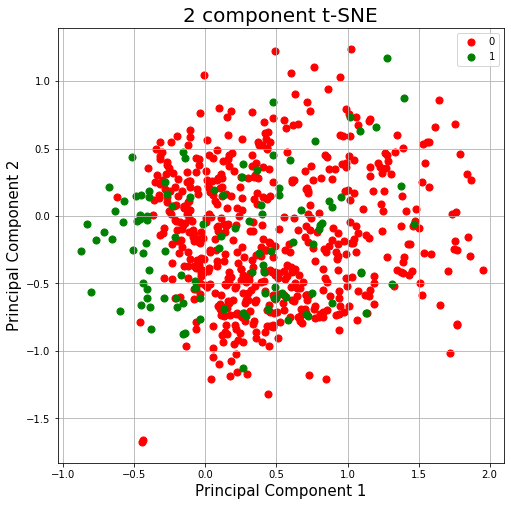

In [23]:
# visualisasi embedding churn dan not churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['churn'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

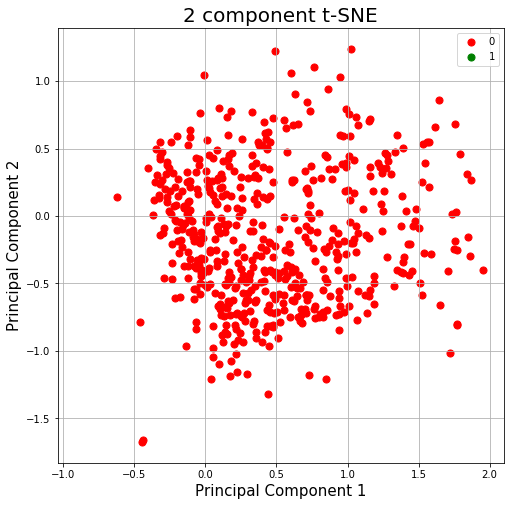

In [24]:
# visualisasi embedding hanya not churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf0['churn'] == target
    ax.scatter(finalDf0.loc[indicesToKeep, 'principal component 1']
               , finalDf0.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

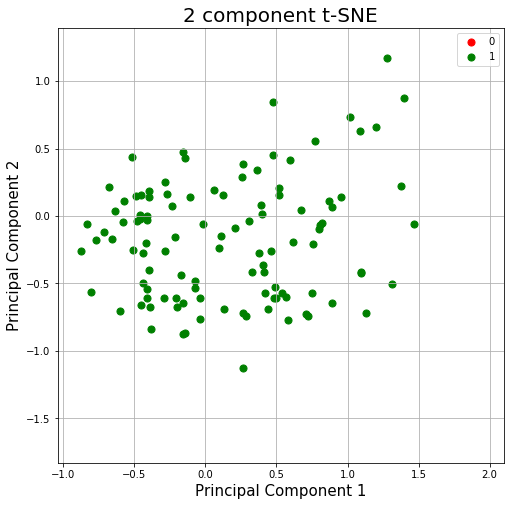

In [25]:
# visualisasi embedding hanya churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf1['churn'] == target
    ax.scatter(finalDf1.loc[indicesToKeep, 'principal component 1']
               , finalDf1.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [26]:
# =============================================================================================
# [26 Mei 2020]: 
# Selain F1 Score, dilaporkan juga rasio jarak antara embedding intra cluster dan inter cluster
#
# jarak embedding intra cluster adalah jarak antara embedding di suatu kelas ke vector yang ada
# di tengah-tengah kelas tersebut (centroid/center). Jarak diukur dengan Cosine similarity.
# semakin besar angka cosine similarity, semakin kecil jarak yang diukur.
#
# jarak embedding inter cluster adalah jarak antara embedding di suatu kelas ke center dari 
# kelas yang lain (centroid/center). Jarak diukur juga dengan Cosine similarity
#
# Karena definisi dari cosine similarity, maka semakin besar ratio inter:intra, semakin baik  
# performa algoritmanya. Bisa dibandingkan bahwa ratio yang dimiliki algoritma dengan LMCLoss
# lebih besar dari ratio dengan Cross Entropy Loss biasa. Kesimpulannya, LMCLoss lebih baik dari
# cross entropy loss
# =============================================================================================

notchurn_emb = x1[test_outputs==0]
sum_notchurn = x1[test_outputs==0].sum(dim=0)
center_notchurn = sum_notchurn/sum_notchurn.norm(p=2)
center_notchurn = center_notchurn.unsqueeze(0)

churn_emb = x1[test_outputs==1]
sum_churn = x1[test_outputs==1].sum(dim=0)
center_churn = sum_churn/sum_churn.norm(p=2)
center_churn = center_churn.unsqueeze(0)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

notchurn_centnotchurn_sim = cos(notchurn_emb, center_notchurn).mean()
notchurn_centchurn_sim = cos(notchurn_emb, center_churn).mean()
churn_centchurn_sim = cos(churn_emb, center_churn).mean()
churn_centnotchurn_sim = cos(churn_emb, center_notchurn).mean()

print("emb not churn, center not churn (not churn intra-cluster): ", notchurn_centnotchurn_sim)
print("emb not churn, center churn (not churn inter-cluster): ", notchurn_centchurn_sim)
print("emb churn, center churn (churn intra-cluster): ", churn_centchurn_sim)
print("emb churn, center not churn (churn inter-cluster): ", churn_centnotchurn_sim)

print("not churn inter-intra cluster ratio: ", notchurn_centnotchurn_sim/notchurn_centchurn_sim)
print("churn inter-intra cluster ratio: ", churn_centchurn_sim/churn_centnotchurn_sim)

emb not churn, center not churn (not churn intra-cluster):  tensor(0.7720, grad_fn=<MeanBackward0>)
emb not churn, center churn (not churn inter-cluster):  tensor(0.7371, grad_fn=<MeanBackward0>)
emb churn, center churn (churn intra-cluster):  tensor(0.7488, grad_fn=<MeanBackward0>)
emb churn, center not churn (churn inter-cluster):  tensor(0.6966, grad_fn=<MeanBackward0>)
not churn inter-intra cluster ratio:  tensor(1.0473, grad_fn=<DivBackward0>)
churn inter-intra cluster ratio:  tensor(1.0749, grad_fn=<DivBackward0>)
